In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from torch.optim import Adam
import itertools
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score
import numpy as np
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def get_data(data="MNIST", batch_size=128):
    # Datasets loading
    data_dir = f"./data/{data}/"
    if data == "MNIST":
        train_dataset = datasets.MNIST(
            root="./mnist_data/",
            train=True,
            transform=transforms.Compose(
                [transforms.ToTensor(), transforms.Lambda(torch.flatten)]
            ),
            download=True,
        )
        test_dataset = datasets.MNIST(
            root="./mnist_data/",
            train=False,
            transform=transforms.Compose(
                [transforms.ToTensor(), transforms.Lambda(torch.flatten)]
            ),
            download=False,
        )
    elif data == "FashionMNIST":
        train_dataset = datasets.FashionMNIST(
            root="./mnist_data/",
            train=True,
            transform=transforms.Compose(
                [transforms.ToTensor(), transforms.Lambda(torch.flatten)]
            ),
            download=True,
        )
        test_dataset = datasets.FashionMNIST(
            root="./mnist_data/",
            train=False,
            transform=transforms.Compose(
                [transforms.ToTensor(), transforms.Lambda(torch.flatten)]
            ),
            download=False,
        )
    # Data Loader (Input Pipeline)
    train_loader = DataLoader(
        dataset=train_dataset, batch_size=batch_size, shuffle=True
    )
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader


def get_hidden_layer(in_dim, out_dim):
    return [nn.Linear(in_dim, out_dim), nn.ReLU(True)]


class Encoder(nn.Module):
    def __init__(self, input_dim=784, hidden_dims=[500, 500, 2000], stat_dim=10):
        super(Encoder, self).__init__()
        self.mu_l = nn.Linear(hidden_dims[-1], stat_dim)
        self.log_sigma2_l = nn.Linear(hidden_dims[-1], stat_dim)
        self.encoder = nn.Sequential(
            *get_hidden_layer(input_dim, hidden_dims[0]),
            *get_hidden_layer(hidden_dims[0], hidden_dims[1]),
            *get_hidden_layer(hidden_dims[1], hidden_dims[2]),
        )

    def forward(self, x):
        e = self.encoder(x)
        return self.mu_l(e), self.log_sigma2_l(e)


class Decoder(nn.Module):
    def __init__(self, input_dim=784, hidden_dims=[500, 500, 2000], stat_dim=10):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            *get_hidden_layer(stat_dim, hidden_dims[-1]),
            *get_hidden_layer(hidden_dims[-1], hidden_dims[-2]),
            *get_hidden_layer(hidden_dims[-2], hidden_dims[-3]),
            nn.Linear(hidden_dims[-3], input_dim),
            nn.Sigmoid(),
        )

    def forward(self, z):
        x_pro = self.decoder(z)
        return x_pro


class VaDE(nn.Module):
    def __init__(
        self,
        n_clusters,
        stat_dim,
        hidden_dims=[500, 500, 2000],
        input_dim=784,
        cuda=True,
    ):
        super(VaDE, self).__init__()
        self.n_clusters = n_clusters
        self.stat_dim = stat_dim
        self.cuda = torch.cuda.is_available() and cuda
        self.encoder = Encoder(
            input_dim=input_dim, hidden_dims=hidden_dims, stat_dim=stat_dim
        )
        self.decoder = Decoder(
            input_dim=input_dim, hidden_dims=hidden_dims, stat_dim=stat_dim
        )
        self.pi_ = nn.Parameter(
            torch.FloatTensor(
                self.n_clusters,
            ).fill_(1)
            / self.n_clusters,
            requires_grad=True,
        )
        self.mu_c = nn.Parameter(
            torch.FloatTensor(self.n_clusters, self.stat_dim).fill_(0),
            requires_grad=True,
        )
        self.log_sigma2_c = nn.Parameter(
            torch.FloatTensor(self.n_clusters, self.stat_dim).fill_(0),
            requires_grad=True,
        )
        if self.cuda:
            self.to("cuda")
            #self = nn.DataParallel(self, device_ids=range(4))

    def pre_train(self, dataloader, pre_epoch=10):
        if not os.path.exists("./pretrained_model.pk"):
            Loss_fn = nn.MSELoss()
            opti = Adam(
                itertools.chain(self.encoder.parameters(), self.decoder.parameters())
            )
            print("Pretraining......")
            epoch_bar = tqdm(range(pre_epoch))
            for _ in epoch_bar:
                L = 0
                for x, y in dataloader:
                    if self.cuda:
                        x = x.cuda()

                    z, _ = self.encoder(x)
                    x_ = self.decoder(z)
                    loss = Loss_fn(x, x_)

                    L += loss.detach().cpu().numpy()

                    opti.zero_grad()
                    loss.backward()
                    opti.step()
                epoch_bar.write("L2={:.4f}".format(L / len(dataloader)))
            self.encoder.log_sigma2_l.load_state_dict(self.encoder.mu_l.state_dict())
            Z = []
            Y = []
            with torch.no_grad():
                for x, y in dataloader:
                    if self.cuda:
                        x = x.cuda()
                    z1, z2 = self.encoder(x)
                    assert F.mse_loss(z1, z2) == 0
                    Z.append(z1)
                    Y.append(y)
            Z = torch.cat(Z, 0).detach().cpu().numpy()
            Y = torch.cat(Y, 0).detach().numpy()
            gmm = GaussianMixture(n_components=self.n_clusters, covariance_type="diag")
            pre = gmm.fit_predict(Z)
            if self.cuda:
                self.pi_.data = torch.from_numpy(gmm.weights_).cuda().float()
                self.mu_c.data = torch.from_numpy(gmm.means_).cuda().float()
                self.log_sigma2_c.data = torch.log(
                    torch.from_numpy(gmm.covariances_).cuda().float()
                )
            else:
                self.pi_.data = torch.from_numpy(gmm.weights_).float()
                self.mu_c.data = torch.from_numpy(gmm.means_).float()
                self.log_sigma2_c.data = torch.log(
                    torch.from_numpy(gmm.covariances_).float()
                )
            torch.save(self.state_dict(), "./pretrained_model.pk")
        else:
            self.load_state_dict(torch.load("./pretrained_model.pk"))

    def train(self, dataloader, epochs=100, lr=2e-3, gamma=0.95):
        opti = Adam(self.parameters(), lr=lr)
        lr_s = StepLR(opti, step_size=10, gamma=gamma)
        writer = SummaryWriter("./logs")
        epoch_bar = tqdm(range(epochs))
        for epoch in epoch_bar:
            L = 0
            for x, _ in dataloader:
                if self.cuda:
                    x = x.cuda()
                loss = vade.ELBO_Loss(x)
                opti.zero_grad()
                loss.backward()
                opti.step()
                L += loss.detach().cpu().numpy()
            lr_s.step()
            writer.add_scalar("loss", L / len(dataloader), epoch)
            writer.add_scalar("lr", lr_s.get_last_lr()[0], epoch)
            epoch_bar.write(
                "Loss={:.4f},LR={:.4f}".format(L / len(dataloader), lr_s.get_last_lr()[0])
            )

    def predict_proba(self, x):
        z_mu, z_sigma2_log = self.encoder(x)
        z = torch.randn_like(z_mu) * torch.exp(z_sigma2_log / 2) + z_mu
        y_c = torch.exp(
            torch.log(self.pi_.unsqueeze(0))
            + self.gaussian_pdfs_log(z)
        )
        return y_c


    def predict(self, x):
        y_c = self.predict_proba(x)
        y = y_c.detach().cpu().numpy()
        return np.argmax(y, axis=1)

    def ELBO_Loss(self, x, L=1, det=1e-10):
        L_rec = 0
        z_mu, z_sigma2_log = self.encoder(x)
        for l in range(L):
            z = torch.randn_like(z_mu) * torch.exp(z_sigma2_log / 2) + z_mu
            x_pro = self.decoder(z)  # x_pro sometimes has nans
            try:
                L_rec += F.binary_cross_entropy(x_pro, x)
            except:
                print(x_pro.min(), x_pro.max())
        L_rec = L_rec / L
        Loss = L_rec * x.size(1)
        z = torch.randn_like(z_mu) * torch.exp(z_sigma2_log / 2) + z_mu
        y_c = (
            torch.exp(
                torch.log(self.pi_.unsqueeze(0))
                + self.gaussian_pdfs_log(z)
            )
            + det
        )
        y_c = y_c / (y_c.sum(1).view(-1, 1))  # batch_size*Clusters
        Loss += 0.5 * torch.mean(
            torch.sum(
                y_c
                * torch.sum(
                    self.log_sigma2_c.unsqueeze(0)
                    + torch.exp(
                        z_sigma2_log.unsqueeze(1) - self.log_sigma2_c.unsqueeze(0)
                    )
                    + (z_mu.unsqueeze(1) - self.mu_c.unsqueeze(0)).pow(2)
                    / torch.exp(self.log_sigma2_c.unsqueeze(0)),
                    2,
                ),
                1,
            )
        )
        Loss -= torch.mean(
            torch.sum(y_c * torch.log(self.pi_.unsqueeze(0) / (y_c)), 1)
        ) + 0.5 * torch.mean(torch.sum(1 + z_sigma2_log, 1))
        return Loss

    def gaussian_pdfs_log(self, x):
        G = []
        for c in range(self.n_clusters):
            G.append(
                self.gaussian_pdf_log(
                    x, self.mu_c[c : c + 1, :], self.log_sigma2_c[c : c + 1, :]
                ).view(-1, 1)
            )
        return torch.cat(G, 1)

    def sample_clusters(self):
        _, n_features = self.mu_c.shape
        rng = np.random.default_rng()
        n_samples_comp = np.ones(10, dtype=np.int8)
        means = self.mu_c.detach().cpu().numpy()
        covs = torch.exp(self.log_sigma2_c).detach().cpu().numpy()
        if True:
            X = np.vstack(
                [
                    mean
                    + rng.standard_normal(size=(sample, n_features))
                    * np.sqrt(covariance)
                    for (mean, covariance, sample) in zip(
                        means, covs, n_samples_comp
                    )
                ]
            )

        y = np.concatenate(
            [np.full(sample, j, dtype=int) for j, sample in enumerate(n_samples_comp)]
        )
        return X,y

    @staticmethod
    def gaussian_pdf_log(x, mu, log_sigma2):
        return -0.5 * (
            torch.sum(
                np.log(np.pi * 2)
                + log_sigma2
                + (x - mu).pow(2) / torch.exp(log_sigma2),
                1,
            )
        )


In [8]:
from tqdm import tqdm
import numpy as np
from torch.optim import Adam
from sklearn.metrics import accuracy_score
from torch.optim.lr_scheduler import StepLR
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn


batch_size=800
n_clusters=10
stat_dim=10

DL_train, DL_test= get_data('MNIST',batch_size)
vade=VaDE(n_clusters, stat_dim)
vade.pre_train(DL_train, pre_epoch=5)
vade.train(DL_train, epochs=30)

Pretraining......


 20%|██        | 1/5 [00:07<00:31,  7.90s/it]

L2=0.0779


 40%|████      | 2/5 [00:14<00:21,  7.06s/it]

L2=0.0558


 60%|██████    | 3/5 [00:21<00:14,  7.12s/it]

L2=0.0445


 80%|████████  | 4/5 [00:27<00:06,  6.81s/it]

L2=0.0339


100%|██████████| 5/5 [00:35<00:00,  7.05s/it]


L2=0.0284


  3%|▎         | 1/30 [00:08<04:05,  8.48s/it]

Loss=168.5342,LR=0.0020


  7%|▋         | 2/30 [00:16<03:55,  8.40s/it]

Loss=128.2384,LR=0.0020


 10%|█         | 3/30 [00:24<03:35,  7.97s/it]

Loss=121.5708,LR=0.0020


 13%|█▎        | 4/30 [00:32<03:28,  8.00s/it]

Loss=117.6786,LR=0.0020


 17%|█▋        | 5/30 [00:40<03:23,  8.13s/it]

Loss=114.9244,LR=0.0020


 20%|██        | 6/30 [00:48<03:14,  8.09s/it]

Loss=112.5234,LR=0.0020


 23%|██▎       | 7/30 [00:56<03:05,  8.04s/it]

Loss=110.7819,LR=0.0020


 27%|██▋       | 8/30 [01:04<02:54,  7.93s/it]

Loss=109.2795,LR=0.0020


 30%|███       | 9/30 [01:11<02:41,  7.71s/it]

Loss=107.9425,LR=0.0020


 33%|███▎      | 10/30 [01:19<02:38,  7.90s/it]

Loss=107.1026,LR=0.0019


 37%|███▋      | 11/30 [01:26<02:24,  7.63s/it]

Loss=106.0579,LR=0.0019


 40%|████      | 12/30 [01:34<02:18,  7.69s/it]

Loss=105.3049,LR=0.0019


 43%|████▎     | 13/30 [01:42<02:12,  7.78s/it]

Loss=104.5730,LR=0.0019


 47%|████▋     | 14/30 [01:49<02:01,  7.58s/it]

Loss=103.9709,LR=0.0019


 50%|█████     | 15/30 [01:58<01:56,  7.76s/it]

Loss=103.4175,LR=0.0019


 53%|█████▎    | 16/30 [02:05<01:46,  7.60s/it]

Loss=102.7518,LR=0.0019


 57%|█████▋    | 17/30 [02:13<01:40,  7.70s/it]

Loss=102.1619,LR=0.0019


 60%|██████    | 18/30 [02:20<01:32,  7.70s/it]

Loss=101.6184,LR=0.0019


 63%|██████▎   | 19/30 [02:28<01:23,  7.63s/it]

Loss=101.2369,LR=0.0019


 67%|██████▋   | 20/30 [02:36<01:17,  7.74s/it]

Loss=100.6850,LR=0.0018


 70%|███████   | 21/30 [02:43<01:07,  7.51s/it]

Loss=100.1436,LR=0.0018


 73%|███████▎  | 22/30 [02:51<01:01,  7.71s/it]

Loss=99.6477,LR=0.0018


 77%|███████▋  | 23/30 [02:59<00:54,  7.81s/it]

Loss=99.4481,LR=0.0018


 80%|████████  | 24/30 [03:06<00:45,  7.55s/it]

Loss=98.9325,LR=0.0018


 83%|████████▎ | 25/30 [03:14<00:38,  7.71s/it]

Loss=98.6044,LR=0.0018


 87%|████████▋ | 26/30 [03:21<00:29,  7.49s/it]

Loss=98.3939,LR=0.0018


 90%|█████████ | 27/30 [03:29<00:23,  7.67s/it]

Loss=97.9740,LR=0.0018


 93%|█████████▎| 28/30 [03:37<00:15,  7.82s/it]

Loss=97.6733,LR=0.0018


 97%|█████████▋| 29/30 [03:44<00:07,  7.56s/it]

Loss=97.4694,LR=0.0018


100%|██████████| 30/30 [03:52<00:00,  7.76s/it]

Loss=97.1743,LR=0.0017


In [17]:
def loader_to_tensor(data_loader):
    X, Y = [], []
    for x,y in data_loader:
        X.append(x)
        Y.append(y)
    X = torch.cat(X, 0).to(device)
    Y = torch.cat(Y, 0)
    return X, Y

x_test, y_test = loader_to_tensor(DL_test)
x_train, y_train = loader_to_tensor(DL_train)

# 1. Evaluate

In [10]:
from sklearn.metrics import rand_score, adjusted_rand_score, adjusted_mutual_info_score, homogeneity_score, fowlkes_mallows_score

In [18]:
y_test_hat = vade.predict(x_test)
#rand isn't scale to 0, adjusted is scaled so random is = 0, mi is mi
#higher is better
rand_score(y_test, y_test_hat), adjusted_rand_score(y_test, y_test_hat), adjusted_mutual_info_score(y_test, y_test_hat), homogeneity_score(y_test, y_test_hat), fowlkes_mallows_score(y_test, y_test_hat)

(0.8897067906790679,
 0.5036085925609295,
 0.6283777286032284,
 0.5757471702798101,
 0.5761075190654005)

# 2. Compare

In [19]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

In [22]:
# not sure if to use latent space or real space?
# silhouette_score compares only with the closest cluster
# ch - higher is better, db - lower (0) is better
z_test_pred = vade.encoder.encoder(x_test).detach().cpu().numpy()
x_test = x_test.cpu()
print('Real space', calinski_harabasz_score(x_test, y_test_hat), davies_bouldin_score(x_test, y_test_hat))
print('Latent space', calinski_harabasz_score(z_test_pred, y_test_hat), davies_bouldin_score(z_test_pred, y_test_hat))

Real space 419.3983886579722 3.290893969501145
Latent space 1000.3260418691254 2.0732241657910317


# 3. Visualize

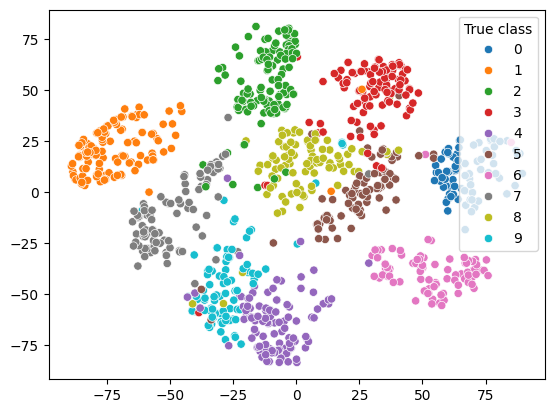

In [23]:
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
tsne = TSNE(n_components=2)
z_test_pred_tsne = tsne.fit_transform(z_test_pred) # test or train?
N=1000
sns.scatterplot(x=z_test_pred_tsne[:N,0], y=z_test_pred_tsne[:N,1], hue=y_test[:N], palette=sns.color_palette("tab10"))
plt.legend(title='True class')
plt.show()

# 4. Visualize generated

In [24]:
import matplotlib.pyplot as plt

In [28]:
Z, y = vade.sample_clusters()
X_gen = vade.decoder(torch.Tensor(Z))
y_train_hat = vade.predict(x_train)
x_train = x_train.cpu()

In [31]:
data = []
for label in y:
    curr_vec = X_gen[label]
    in_cluster_data = x_train[y_train_hat==label]
    out_cluster_data = x_train[y_train_hat!=label]
    in_vec, in_closest_dist = None, None
    out_vec, out_closest_dist = None, None
    if len(in_cluster_data)>0:
        in_dist = torch.sqrt(torch.sum((in_cluster_data - curr_vec) ** 2, dim=1))
        in_closest_dist, in_closest_index = torch.min(in_dist), torch.argmin(in_dist)
        in_vec = in_cluster_data[in_closest_index]
    if len(out_cluster_data)>0:
        out_dist = torch.sqrt(torch.sum((out_cluster_data - curr_vec) ** 2, dim=1))
        out_closest_dist, out_closest_index = torch.min(out_dist), torch.argmin(out_dist)
        out_vec = out_cluster_data[out_closest_index]
    data.append([curr_vec, in_vec, in_closest_dist, out_vec, out_closest_dist, label])

<Figure size 640x480 with 0 Axes>

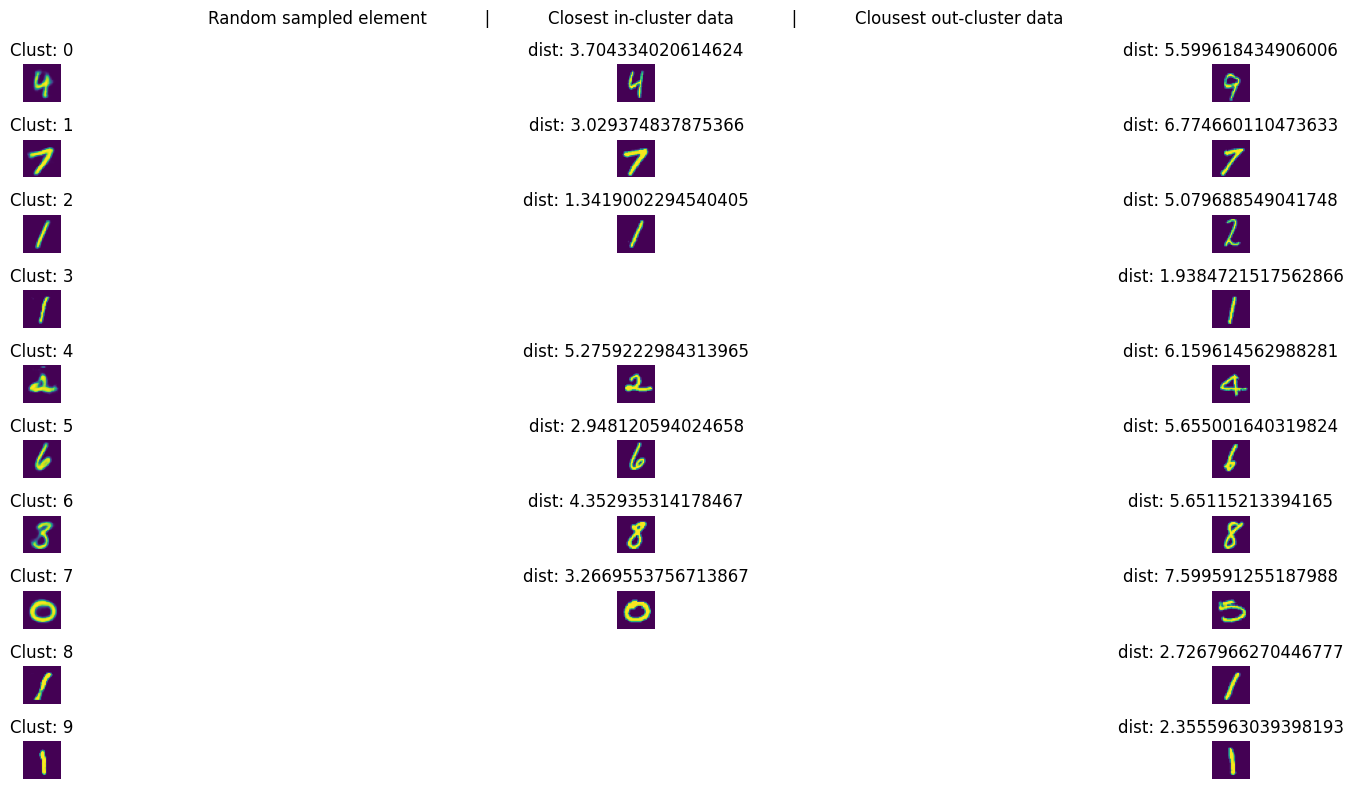

In [32]:
plt.figure()
fig, axes = plt.subplots(nrows=10, ncols=3, figsize=(20,8))
fig.suptitle("Random sampled element           |           Closest in-cluster data           |           Clousest out-cluster data")
to_img = lambda img: torch.unflatten(img, 0, (28,28)).detach().numpy()
for list_elems, ax in zip(data, axes):
    titles = [f"Clust: {list_elems[-1]}", f"dist: {list_elems[2]}", f"dist: {list_elems[4]}"]
    for j, ind, title in zip([list_elems[0], list_elems[1], list_elems[3]], [0,1,2], titles):
        ax[ind].set_axis_off()
        if j is not None:
            ax[ind].imshow(to_img(j))
            ax[ind].set_title(title)
plt.tight_layout()
plt.show()